This code is meant to display the ratio of sales within a week. The point is that some products may have bigger sales on a specific weekday: for example, on Tuesdays. This information can be taken into account for replenishment planning. It will help specialists from supply planning or customer service departments to prepare for days with either low or high sales.

The first part of the code is taken from Service-Level-and-Coverage-KPIs script.

In [1]:
import numpy as np
import pandas as pd
import sidetable as stb
import glob, os
from datetime import datetime, timedelta, date
import matplotlib.style as style
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
pd.options.display.float_format = '{:.0f}%'.format

In [3]:
pd.set_option('display.width', 150)
pd.options.display.max_colwidth = 150

Below you can see a sample of initial data. Later it will be divided in columns.

In [4]:
SamplePath = r'C:\Users\БФедин\OneDrive - GENERIX\InventoryReports\Baltika\MVT_Baltika_20201208.txt'

SampleFile = pd.read_fwf(SamplePath,header=None)
print(SampleFile.head())

                                                                0
0  01468032853241246006825754740000200712202000000114401000105264
1  04468032853241246006825754740000200712202000000008601000105264
2  03468032853241246006825754740000200712202000000000401000105264
3  01468032853241246006826632010000200712202000000016461000162982
4  04468032853241246006826632010000200712202000000000001000162982


In [5]:
path = r'C:\Users\БФедин\OneDrive - GENERIX\InventoryReports\Baltika'
all_files = glob.glob(path + "/*.txt")

In [6]:
col_specification = [(0,2),(2,15),(15,28),(28,30),
                     (30,34),(34,36),(36,38),(38,42),(42,52),(52,62)]

In [7]:
li = []

for filename in all_files:
    df = pd.read_fwf(filename, header=None,colspecs=col_specification,float_format='%.f')
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

df = df.dropna() # Script drops N/A values. They may appear if file has blank lines.

df.columns = ['Movement_Code','GLN_Code','EAN_Code','Site_Item_Type',
                  'Case_Count','Movement_Day','Movement_Month','Movement_Year',
                    'Quantity','Base_Unit_Code']

In [8]:
df[['GLN_Code','EAN_Code','Base_Unit_Code','Case_Count']] = \
df[['GLN_Code','EAN_Code','Base_Unit_Code','Case_Count']].astype(str).replace('\.0', '', regex=True)

df['Quantity'] = df['Quantity'].astype(int)

In [9]:
df['Movement_Day'] = df['Movement_Day'].astype(str).replace('\.0', '', regex=True)
df['Movement_Day'] = df['Movement_Day'].str.zfill(2)
df['Movement_Month'] = df['Movement_Month'].astype(str).replace('\.0', '', regex=True)
df['Movement_Month'] = df['Movement_Month'].str.zfill(2)
df['Movement_Year'] = df['Movement_Year'].apply(str).replace('\.0', '', regex=True)
df['Movement_Date'] = df["Movement_Day"] + "-" + df["Movement_Month"] + "-" + df["Movement_Year"]
df['Movement_Date'] = df['Movement_Date'].apply(str).replace('\.0', '', regex=True)
df['Movement_Date'] = pd.to_datetime(df.Movement_Date,format = '%d-%m-%Y', dayfirst=True)
df = df.drop(['Movement_Day','Movement_Month','Movement_Year'], axis=1) 

In [10]:
if 5 in df['Movement_Code']:
    df['Movement_Code'] = df['Movement_Code'].replace([1,4,3,5],
                                                      ['Stock','Transit','Shipped','OOS'])
else: 
    df['Movement_Code'] = df['Movement_Code'].replace([1,4,3],
                                                      ['Stock','Transit','Shipped'])

In [11]:
df['Site_Item_Type'] = df['Site_Item_Type'].replace([0,1],
                                                    ['Standard','Promo'])

In [12]:
df = df[['Movement_Code','GLN_Code','EAN_Code','Site_Item_Type',
                  'Case_Count','Movement_Date','Quantity','Base_Unit_Code']]

In [13]:
dfPivot = pd.pivot_table(df,aggfunc='sum',values='Quantity',
                         index=['Movement_Date','EAN_Code','Base_Unit_Code'],
                         columns='Movement_Code').reset_index()

In [14]:
dfPivot = dfPivot.fillna(0)

In [15]:
if 'OOS' in df['Movement_Code'].unique():
    dfPivot['OOS'] = dfPivot['OOS'].fillna(0)
    dfPivot['Demand'] = dfPivot['Shipped'] + dfPivot['OOS']
else:
    dfPivot['OOS'] = dfPivot['OOS'].fillna(0)
    dfPivot['Demand'] = dfPivot['Shipped']

In [16]:
dfPivot['Movement_Week'] = 'cw'+dfPivot['Movement_Date'].dt.strftime('%V')

In [17]:
Movement_Codes_Order = ['Movement_Week','Movement_Weekday','Movement_Date','EAN_Code','Base_Unit_Code',
                        'Stock','Transit','Shipped','OOS','Demand']

dfPivot = dfPivot.reindex(Movement_Codes_Order,axis=1)

In [18]:
dfPivot.iloc[:, 5:] = dfPivot.iloc[:, 5:].astype(int)

In [19]:
dfPivot = dfPivot.rename_axis("Line_ID",axis=1)

In [20]:
dfPivot = dfPivot.sort_values(by=['Movement_Date'],ascending=False,inplace=False)

In [21]:
dfPivot['Movement_Weekday'] = dfPivot['Movement_Date'].dt.day_name()

In [22]:
print(dfPivot.head())

Line_ID Movement_Week Movement_Weekday Movement_Date       EAN_Code Base_Unit_Code  Stock  Transit  Shipped  OOS  Demand
5096             cw52         Thursday    2020-12-24  4600682663201     1000162982    166        0        0    0       0
5067             cw52         Thursday    2020-12-24  4600682004677     1000234512    475        0       36    0      36
5075             cw52         Thursday    2020-12-24  4600682023135     1000323217   4260        0       20    0      20
5074             cw52         Thursday    2020-12-24  4600682023128     1000323216   5559        0       20    0      20
5073             cw52         Thursday    2020-12-24  4600682019220     1000306461    467      945       90    0      90


Code above is an extract from Service Level and Coverage KPIs script.
___________

Below we create a function that can build a bar chart with weekly demand split in weekdays.

As parameters user can add a **product code** (EAN code in our case) and **number of weeks** that will be observed.

In [25]:
def DayWeightBarChart(ProductCode,WeekCount):
    dfСhart = dfPivot[dfPivot['EAN_Code'] == ProductCode]
    
    dfChart = dfPivot[(dfPivot['Movement_Date'] >= pd.to_datetime(dfPivot['Movement_Date'].max()) - pd.DateOffset(weeks=WeekCount)) &
                      (dfPivot['Movement_Date'] <= pd.to_datetime(dfPivot['Movement_Date'].max()))]
    
    dfTotalDayWeight = pd.pivot_table(dfChart,aggfunc='sum',values='Demand',index=['Movement_Weekday'])
    
    dfTotalDayWeight = dfTotalDayWeight.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
    
    dfTotalDayWeight = dfTotalDayWeight.reset_index()
    
    dfTotalDayWeight['Day_Weight'] = dfTotalDayWeight['Demand'] / dfTotalDayWeight['Demand'].sum() * 100
    
    y = dfTotalDayWeight['Day_Weight']
    
    fig, ax = plt.subplots(figsize=(6,4))

    ax = sns.barplot(data=dfTotalDayWeight,x='Movement_Weekday',y='Day_Weight')
    plt.xlabel('')
    plt.ylabel('')
    plt.title('Day Weight, %',size=15,color='#4f4e4e',pad=30)
    plt.yticks(np.arange(0, max(y), 5))
    plt.xticks(size=13, color='#4f4e4e',rotation=90)
    plt.yticks(size=13, color='#4f4e4e')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    sns.despine(left=True)
    sns.set(style="whitegrid")

    plt.text(x=3, y=plt.ylim()[1]+1.5, s=('Review period: '+str(WeekCount)+' week(s)'), 
                 color='#4f4e4e', fontsize=12, horizontalalignment='center')

    plt.text(x=3, y=plt.ylim()[1], s=('Product code: '+str(ProductCode)),
                 color='#4f4e4e', fontsize=12, horizontalalignment='center')


    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=12,
                   xytext = (0, -12),
                   textcoords = 'offset points',
                   color='white')

    plt.show()

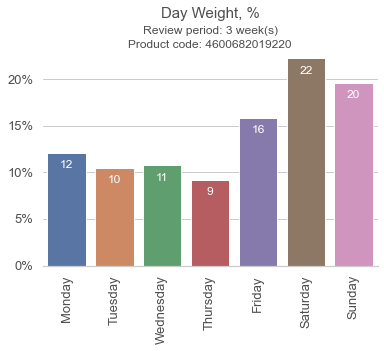

In [26]:
DayWeightBarChart('4600682019220',3)

This bar chart can be helpful in at least 2 cases.

With VMI-driven replenishment this chart can help supply planners or customer service specialists to plan deliveries for retailers. Based on the chart they can decide that it's better not to deliver product 4600682019220 on Thursday (day with lowest sales). However, they need to prepare for Saturday - day with biggest sales. That's why, delivery by the end of Friday would be the best option.

If retailer is planning replenishment on their own, they can also use this bar chart to track sales throughout the week and place orders with a more suitable delivery date.

In both cases such a data-driven replenishment can help responsible specialists to improve stock coverage.